Starting TINN training...
Epoch 00000: Loss = 3.08101207e-01
Epoch 00050: Loss = 4.14893441e-02
Epoch 00100: Loss = 2.23083161e-02
Epoch 00150: Loss = 1.51372124e-02
Epoch 00200: Loss = 8.77962727e-03
Epoch 00250: Loss = 5.68619370e-03
Epoch 00300: Loss = 3.91575973e-03
Epoch 00350: Loss = 3.27523472e-03
Epoch 00400: Loss = 2.66365195e-03
Epoch 00450: Loss = 3.91107891e-03
Epoch 00500: Loss = 2.00378848e-03
Epoch 00550: Loss = 1.62548060e-03
Epoch 00600: Loss = 3.00736912e-03
Epoch 00650: Loss = 1.38324394e-03
Epoch 00700: Loss = 1.13336835e-03
Epoch 00750: Loss = 1.45735452e-02
Epoch 00800: Loss = 9.13810509e-04
Epoch 00850: Loss = 1.08042115e-03
Epoch 00900: Loss = 7.55029265e-04
Epoch 00950: Loss = 6.39843522e-04
Epoch 01000: Loss = 5.68815740e-04
Epoch 01050: Loss = 5.48092416e-04
Epoch 01100: Loss = 5.40859997e-04
Epoch 01150: Loss = 5.33580256e-04
Epoch 01200: Loss = 5.26240678e-04
Epoch 01250: Loss = 5.18848945e-04
Epoch 01300: Loss = 5.11413091e-04
Epoch 01350: Loss = 5.0394516

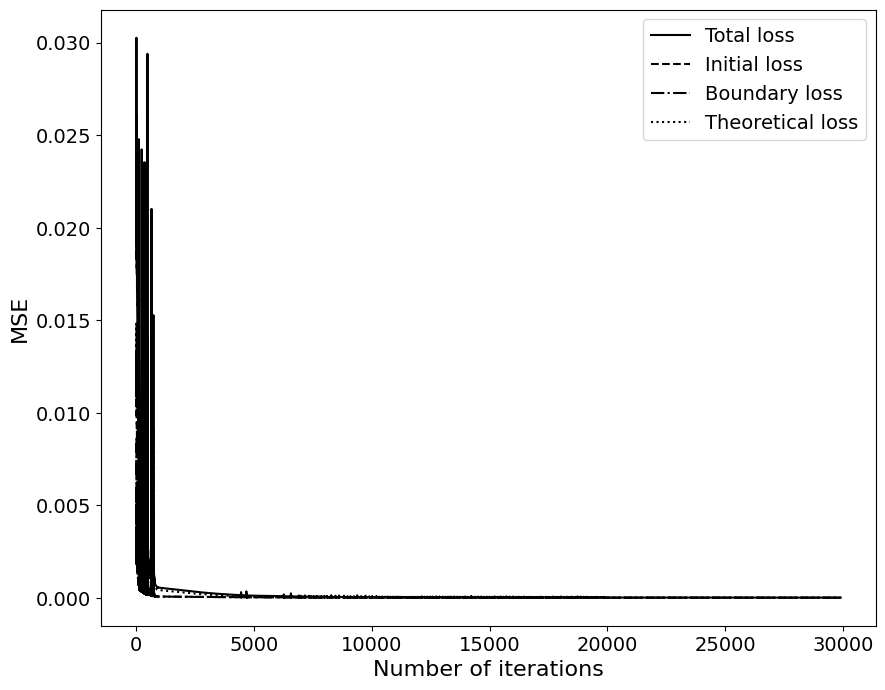

Running finite difference solver...
Finite difference solution completed.


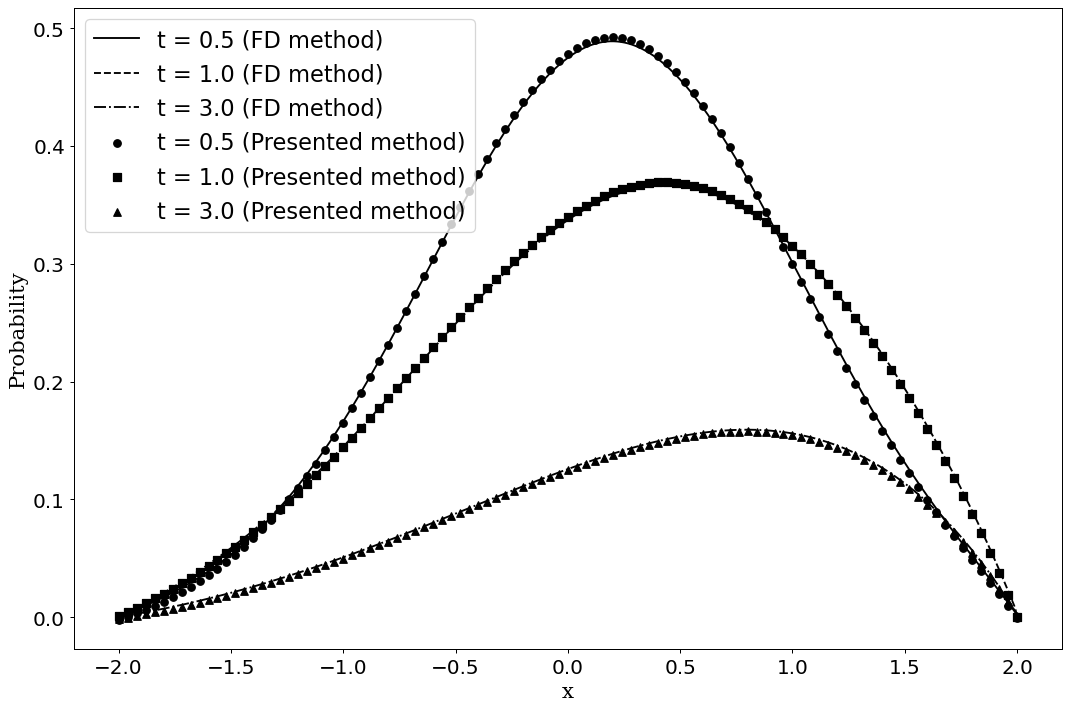

Computing first passage times...


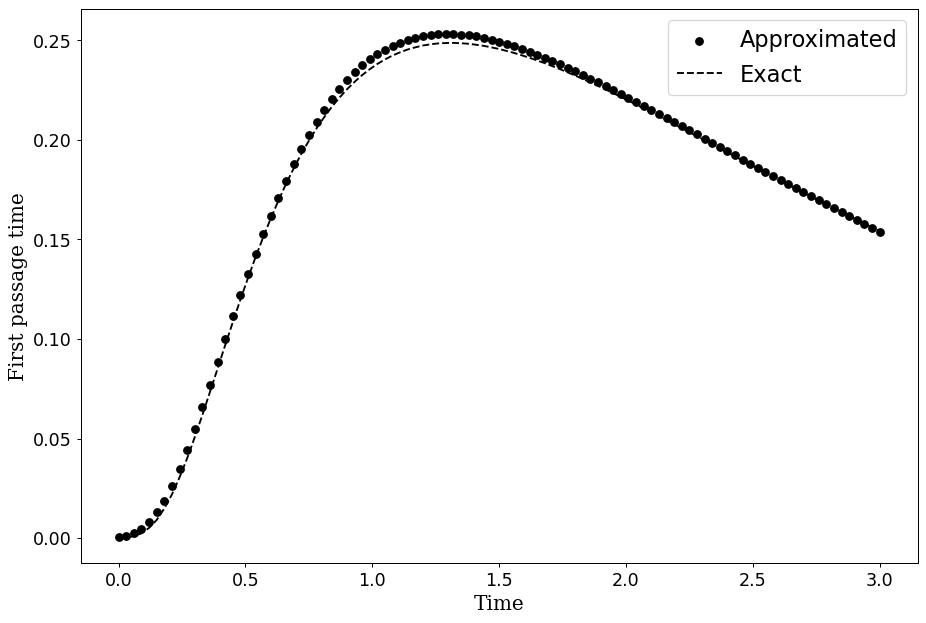

Analysis completed successfully!


In [2]:
"""
Theoretical-Informed Neural Network (TINN) for DDM model
with Time-Dependent Drift and First Passage Time Analysis
"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize

# =============================================================================
# Configuration and Constants
# =============================================================================

# Set data type
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

# Physical parameters
DELTA = 7.8e-2
SIGMA = 1.0
V0 = 0.3
V1 = 0.4
TAU0 = 0.8

# Domain boundaries
TMIN, TMAX = 0.0, 3.0
XMIN, XMAX = -2.0, 2.0

# Training parameters
N_0 = 100    # Initial condition points
N_B = 200    # Boundary condition points
N_R = 5000   # Residual collocation points
NUM_EPOCHS = 30000

# Neural network architecture
NUM_HIDDEN_LAYERS = 3
NUM_NEURONS_PER_LAYER = 30

# =============================================================================
# Physics Definitions
# =============================================================================

def dirac_delta_function(x, delta):
    """Approximate Dirac delta function as a Gaussian distribution."""
    return 1 / (2 * np.sqrt(np.pi * delta)) * tf.math.exp(-((x - 0.0)**2) / (4 * delta))

def time_dependent_drift(t):
    """Define time-dependent drift coefficient."""
    return V0 + V1 * (t / (t + TAU0))

def initial_condition(x):
    """Define initial condition at t=0."""
    return dirac_delta_function(x, DELTA)

def boundary_condition(t, x):
    """Define boundary condition."""
    n = x.shape[0]
    return tf.zeros((n, 1), dtype=DTYPE)

def pde_residual(t, x, u, u_t, u_x, u_xx):
    """Define the PDE residual (Fokker-Planck equation with time-dependent drift)."""
    drift = tf.reshape(time_dependent_drift(t), [tf.shape(t)[0], 1])
    return u_t + drift * u_x - 0.5 * SIGMA**2 * u_xx

# =============================================================================
# Data Preparation
# =============================================================================

def prepare_training_data():
    """Prepare initial, boundary, and collocation points for training."""

    # Domain bounds
    lb = tf.constant([TMIN, XMIN], dtype=DTYPE)
    ub = tf.constant([TMAX, XMAX], dtype=DTYPE)

    # Initial condition data
    t_0 = tf.ones((N_0, 1), dtype=DTYPE) * lb[0]
    x_0 = np.linspace(lb[1], ub[1], N_0 - 1, dtype=DTYPE)
    x_0 = np.asarray(list(x_0) + [0.0])  # Ensure point at x=0 is included
    x_0 = tf.convert_to_tensor(x_0, dtype=DTYPE)
    x_0 = tf.reshape(x_0, [N_0, 1])
    u_0 = initial_condition(x_0)
    X_0 = tf.concat([t_0, x_0], axis=1)

    # Boundary condition data
    t_b = tf.random.uniform((N_B, 1), lb[0], ub[0], dtype=DTYPE)
    x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli(
        (N_B, 1), 0.5, dtype=DTYPE)
    X_b = tf.concat([t_b, x_b], axis=1)
    u_b = boundary_condition(t_b, x_b)

    # Collocation points for PDE residual
    t_r = tf.random.uniform((N_R, 1), lb[0], ub[0], dtype=DTYPE)
    x_r = tf.random.uniform((N_R, 1), lb[1], ub[1], dtype=DTYPE)
    X_r = tf.concat([t_r, x_r], axis=1)

    # Collect all data
    X_data = [X_0, X_b]
    u_data = [u_0, u_b]

    return X_r, X_data, u_data, lb, ub

# =============================================================================
# Neural Network Model
# =============================================================================

def create_model(num_hidden_layers=NUM_HIDDEN_LAYERS, num_neurons_per_layer=NUM_NEURONS_PER_LAYER):
    """Create the TINN model architecture."""
    model = tf.keras.Sequential()

    # Input layer
    model.add(tf.keras.Input(shape=(2,)))

    # Hidden layers
    for _ in range(num_hidden_layers - 1):
        model.add(tf.keras.layers.Dense(
            num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'
        ))

    # Final hidden layer with softplus activation
    model.add(tf.keras.layers.Dense(
        num_neurons_per_layer,
        activation='softplus'
    ))

    # Output layer
    model.add(tf.keras.layers.Dense(1))

    return model

def compute_pde_residual(model, X_r):
    """Compute the PDE residual using automatic differentiation."""
    with tf.GradientTape(persistent=True) as tape:
        # Split inputs
        t, x = X_r[:, 0:1], X_r[:, 1:2]

        # Watch variables for gradient computation
        tape.watch(t)
        tape.watch(x)

        # Compute solution
        u = model(tf.stack([t[:, 0], x[:, 0]], axis=1))

        # Compute first derivatives
        u_x = tape.gradient(u, x)

    # Compute higher derivatives
    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)

    del tape

    return pde_residual(t, x, u, u_t, u_x, u_xx)

# =============================================================================
# Training Utilities
# =============================================================================

def compute_loss(model, X_r, X_data, u_data):
    """Compute the total loss function."""
    # PDE residual loss
    r = compute_pde_residual(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))

    # Initial condition loss
    u_pred_0 = model(X_data[0])
    loss_ic = tf.reduce_mean(tf.square(u_data[0] - u_pred_0))

    # Boundary condition loss
    u_pred_1 = model(X_data[1])
    loss_bc = tf.reduce_mean(tf.square(u_data[1] - u_pred_1))

    # Total loss
    total_loss = phi_r + loss_ic + loss_bc

    return total_loss, phi_r, loss_ic, loss_bc

def get_gradients(model, X_r, X_data, u_data):
    """Compute gradients of the loss function."""
    with tf.GradientTape(persistent=True) as tape:
        loss, loss_pde, loss_ic, loss_bc = compute_loss(
            model, X_r, X_data, u_data)

    gradients = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, gradients, loss_pde, loss_ic, loss_bc

def setup_optimizer():
    """Setup the optimizer with learning rate schedule."""
    lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        [1000, 5000, 20000],
        [1e-2, 1e-3, 5e-4, 1e-4]
    )
    return tf.keras.optimizers.Adam(learning_rate=lr_schedule)

@tf.function
def train_step(model, X_r, X_data, u_data, optimizer):
    """Single training step."""
    loss, gradients, loss_pde, loss_ic, loss_bc = get_gradients(
        model, X_r, X_data, u_data)

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, loss_pde, loss_ic, loss_bc

def train_model(model, X_r, X_data, u_data):
    """Train the TINN model."""
    optimizer = setup_optimizer()

    # History tracking
    history = {
        'total_loss': [],
        'pde_loss': [],
        'ic_loss': [],
        'bc_loss': []
    }

    print("Starting TINN training...")
    t0 = time()

    for epoch in range(NUM_EPOCHS + 1):
        loss, loss_pde, loss_ic, loss_bc = train_step(
            model, X_r, X_data, u_data, optimizer)

        # Store history
        history['total_loss'].append(loss.numpy())
        history['pde_loss'].append(loss_pde.numpy())
        history['ic_loss'].append(loss_ic.numpy())
        history['bc_loss'].append(loss_bc.numpy())

        # Print progress
        if epoch % 50 == 0:
            print(f'Epoch {epoch:05d}: Loss = {loss.numpy():10.8e}')

    training_time = time() - t0
    print(f'\nTraining completed in {training_time:.2f} seconds')

    return history

# =============================================================================
# Finite Difference Solver
# =============================================================================

def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    """Create tridiagonal matrix."""
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

def finite_difference_solver():
    """Solve the PDE using finite difference method for validation."""
    # Parameters
    N = 500       # Number of spatial points
    T = 3         # Total time
    dt = 0.03     # Time step

    # Spatial grid
    x = np.linspace(-2, 2, N)
    dx = x[1] - x[0]

    # Initial condition: Gaussian distribution
    P = 1 / (2 * np.sqrt(np.pi * DELTA)) * np.exp(-((x - 0.0)**2) / (4 * DELTA))

    # Time evolution
    timesteps = int(T / dt)
    P_all = np.zeros((N, timesteps + 1))
    P_all[:, 0] = P

    for t in range(timesteps):
        P_new = np.zeros_like(P)
        tt = t * dt

        # Construct matrices for Crank-Nicolson scheme
        a = (-dt/(4 * dx**2) - (time_dependent_drift(tt) * dt)/(4 * dx)) * np.ones((N - 1))
        b = (1 + (dt/(2 * dx**2))) * np.ones((N))
        c = (-dt/(4 * dx**2) + (time_dependent_drift(tt) * dt)/(4 * dx)) * np.ones((N - 1))
        A = tridiag(a, b, c)

        aa = (dt/(4 * dx**2) + (time_dependent_drift(tt) * dt)/(4 * dx)) * np.ones((N - 1))
        bb = (1 - (dt/(2 * dx**2))) * np.ones((N))
        cc = (dt/(4 * dx**2) - (time_dependent_drift(tt) * dt)/(4 * dx)) * np.ones((N - 1))
        B = tridiag(aa, bb, cc)

        # Solve system
        P_new = np.linalg.inv(A) @ B @ P

        # Apply boundary conditions (Dirichlet)
        P_new[0] = 0
        P_new[-1] = 0

        P = P_new
        P_all[:, t + 1] = P

    return P_all, x

# =============================================================================
# First Passage Time Analysis
# =============================================================================

def compute_first_passage_time_tinn(model, lb, ub, N=100):
    """Compute first passage time using TINN solution."""
    tspace = np.linspace(0, ub[0], N + 1)

    # Points at boundary for finite difference
    xspace = np.ones((N + 1)) * ub[1]
    X = np.zeros((N + 1, 2))
    X[:, 0] = tspace
    X[:, 1] = xspace
    X = tf.constant(X, DTYPE)
    p_i = model(X)

    # Points slightly inside for derivative calculation
    xspace1 = np.ones((N + 1)) * (ub[1] - 0.02)
    X1 = np.zeros((N + 1, 2))
    X1[:, 0] = tspace
    X1[:, 1] = xspace1
    X1 = tf.constant(X1, DTYPE)
    p_ii = model(X1)

    xspace2 = np.ones((N + 1)) * (ub[1] - 0.04)
    X2 = np.zeros((N + 1, 2))
    X2[:, 0] = tspace
    X2[:, 1] = xspace2
    X2 = tf.constant(X2, DTYPE)
    p_iii = model(X2)

    # Compute spatial derivative using finite differences
    p_x = (3 * p_i - 4 * p_ii + p_iii) / (2 * 0.02)

    # Compute first passage time
    J1 = np.reshape(time_dependent_drift(tspace), (N + 1, 1)) * p_i - 0.5 * SIGMA**2 * p_x

    return J1.numpy().flatten(), tspace

def compute_first_passage_time_fd(P_all, tspace):
    """Compute first passage time using finite difference solution."""
    N = len(tspace) - 1
    # Compute spatial derivative at boundary using finite differences
    p_x_fd = (3 * P_all[-1, :] - 4 * P_all[-2, :] + P_all[-3, :]) / (2 * 0.02)

    # Compute first passage time
    J1_fd = (np.reshape(time_dependent_drift(tspace), (1, N + 1)) *
             P_all[-1, :] - 0.5 * SIGMA**2 * p_x_fd)

    return J1_fd.flatten()

# =============================================================================
# Visualization Functions
# =============================================================================

def plot_training_history(history):
    """Plot the training loss history."""
    plt.figure(figsize=(10, 8))

    plt.plot(history['total_loss'][100:], label='Total loss',
             color='black', linestyle='-')
    plt.plot(history['ic_loss'][100:], label='Initial loss',
             color='black', linestyle='--')
    plt.plot(history['bc_loss'][100:], label='Boundary loss',
             color='black', linestyle='-.')
    plt.plot(history['pde_loss'][100:], label='Theoretical loss',
             color='black', linestyle=':')

    plt.xlabel('Number of iterations', fontsize=16)
    plt.ylabel('MSE', fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.legend(fontsize=14)
    plt.savefig("loss_plot.pdf", format="pdf", bbox_inches="tight")
    plt.show()

def plot_solution_comparison(model, P_all, x, lb, ub):
    """Plot comparison between TINN and FD solutions at different time points."""
    font = {
        'family': 'serif',
        'color': 'black',
        'weight': 'normal',
        'size': 17,
    }

    plt.figure(figsize=(12, 8), dpi=90)

    # FD solutions
    plt.plot(x, P_all[:, 17], label='t = 0.5 (FD method)',
             color='black', linestyle='-')
    plt.plot(x, P_all[:, 34], label='t = 1.0 (FD method)',
             color='black', linestyle='--')
    plt.plot(x, P_all[:, -1], label='t = 3.0 (FD method)',
             color='black', linestyle='-.')

    # TINN solutions
    t_list = [0.5, 1.0, 3.0]
    labels = ['t = 0.5 (Presented method)',
              't = 1.0 (Presented method)',
              't = 3.0 (Presented method)']
    markers = ['o', 's', '^']  # circle, square, triangle

    for t_val, label, marker in zip(t_list, labels, markers):
        N_points = 100
        xspace = np.linspace(lb[1], ub[1], N_points + 1)
        T_grid, X_grid = np.meshgrid(t_val, xspace)
        Xgrid = np.vstack([T_grid.flatten(), X_grid.flatten()]).T

        # Model prediction
        upred = model(tf.cast(Xgrid, DTYPE))

        # Plot
        plt.scatter(X_grid, upred, label=label,
                    color='black', marker=marker)

    plt.xlabel('x', fontdict=font)
    plt.ylabel('Probability', fontdict=font)
    plt.legend(fontsize=18)
    plt.tick_params(axis='both', labelsize=16)
    plt.tight_layout()
    plt.savefig("solution_comparison.pdf", format="pdf", bbox_inches="tight")
    plt.show()

def plot_first_passage_time_comparison(J1_tinn, J1_fd, tspace):
    """Plot comparison between TINN and FD first passage times."""
    font = {
        'family': 'serif',
        'color': 'black',
        'weight': 'normal',
        'size': 16,
    }

    plt.figure(figsize=(12, 8), dpi=90)

    plt.scatter(tspace, J1_tinn, label='Approximated',
                color='black', marker='o')
    plt.plot(tspace, J1_fd.reshape((len(tspace), 1)), label='Exact',
             color='black', linestyle='--')

    plt.xlabel('Time', fontdict=font)
    plt.ylabel('First passage time', fontdict=font)
    plt.legend(fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.savefig("first_passage_time_comparison.pdf", format="pdf", bbox_inches="tight")
    plt.show()

# =============================================================================
# Main Execution
# =============================================================================

def main():
    """Main function to run the TINN training and analysis."""

    # Prepare training data
    X_r, X_data, u_data, lb, ub = prepare_training_data()

    # Create and train TINN model
    model = create_model()
    history = train_model(model, X_r, X_data, u_data)

    # Generate training plot
    plot_training_history(history)

    # Run finite difference solver for comparison
    print("Running finite difference solver...")
    P_all, x = finite_difference_solver()
    print("Finite difference solution completed.")

    # Plot solution comparison
    plot_solution_comparison(model, P_all, x, lb, ub)

    # Compute and compare first passage times
    print("Computing first passage times...")
    J1_tinn, tspace = compute_first_passage_time_tinn(model, lb, ub, N=100)
    J1_fd = compute_first_passage_time_fd(P_all, tspace)

    # Plot comparison
    plot_first_passage_time_comparison(J1_tinn, J1_fd, tspace)

    print("Analysis completed successfully!")

if __name__ == "__main__":
    main()